Berdasarkan [#102](https://github.com/taruma/hidrokit/issues/102): **upsampling data**

Referensi Isu:
- `hidrokit.contrib.taruma.hk98`. ([manual/notebook](https://gist.github.com/taruma/aca7f90c8fbb0034587809883d0d9e92)\). **buat ringkasan/rekap data deret waktu**

Deskripsi permasalahan:
- Mengubah data bulanan menjadi data harian sehingga dapat di rekap menggunakan fungsi yang tersedia di `hidrokit.contrib.taruma.hk98`.

Strategi penyelesaian:
- Pada melakukan upsampling, nilai yang kosong bisa diisi menggunakan metode interpolasi atau diisi dengan nilai pada awal bulan (_default_).

# PERSIAPAN DAN DATASET

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 5]

In [ ]:
try:
    import hidrokit
except ModuleNotFoundError:
    !pip install git+https://github.com/taruma/hidrokit.git@latest -q
    import hidrokit
print(f'hidrokit version: {hidrokit.__version__}')

hidrokit version: 0.3.5-beta.6


In [ ]:
!wget -O pet.xlsx "https://taruma.github.io/assets/hidrokit_dataset/fjmock_sample.xlsx" -q
!wget -O sta.xlsx "https://taruma.github.io/assets/hidrokit_dataset/data_daily_sample.xlsx" -q
sta_path = 'sta.xlsx'
pet_path = 'sample.xlsx'

In [ ]:
df_pet = (pd.read_excel(pet_path, usecols=[3])
            .set_index(
                pd.date_range('20050101', '20160101', freq='MS', closed='left')
            )
         )
df_pet.head()

,PET
2005-01-01,2.988970
2005-02-01,3.145340
2005-03-01,3.213324
2005-04-01,3.474628
2005-05-01,3.597509


In [ ]:
from hidrokit.contrib.taruma import hk88

df_sta = hk88.read_workbook(sta_path, ['STA_B'])
df_sta.head()

,STA_B
2001-01-01,0
2001-01-02,0
2001-01-03,45
2001-01-04,0
2001-01-05,5


# KODE

In [ ]:
# ref: https://stackoverflow.com/q/29612705/4886384
def upsampling(df, freq='D', fill_method='ffill', 
               use_inter=False, inter_method='linear', inter_keys={}, 
               reindex=False):
    start = df.index.min() - pd.DateOffset(day=1)
    end = df.index.max() - pd.DateOffset(day=31)
    date = pd.date_range(start, end, freq=freq)

    newdf = df.reindex(date)

    if reindex:
        return newdf

    if use_inter:
        return newdf.interpolate(method=inter_method, **inter_keys)
    else:
        return newdf.fillna(method=fill_method)

# PENERAPAN

Pada _notebook_ ini terdapat dua dataset yaitu `df_sta` (data hujan stasiun B) dan `df_pet` (data evapotranspirasi). Dua dataset ini memiliki perbedaan dari jumlah data dan observasinya, pada `df_sta` data dalam bentuk observasi harian, sedangkan pada `df_pet` data berupa observasi bulanan. 

Dalam pemodelan F.J. Mock (`hidrokit.contrib.taruma.hk96`) data masukan bisa memiliki sembarang periode (per 3 hari, 15 hari, dll). Untuk data `df_sta` bisa dilakukan rekap data menggunakan modul `contrib.taruma.hk98`, sedangkan data `df_pet` tidak bisa menyesuaikan dengan periode tersebut karena data bukan data harian.

Fungsi `upsampling` menangani permasalahan tersebut dengan mengubah data bulanan menjadi harian dengan pengisian berbagai metode (interpolasi, atau isian dari awal bulan). 

## Fungsi `upsampling`

Fungsi ini mengubah data bulanan/periode ke data harian dengan menggunakan berbagai metode (isian atau interpolasi). 

Argumen yang harus diberikan:

- `df`: dataset dalam objek `pandas.DataFrame` dengan index berupa objek `DateTimeIndex`/`Timestamp`.

Argumen opsional:

- `fill_method='ffill'`: mengisi data yang kosong dengan metode _forward fill_. Metode merupakan isian valid untuk argumen `method` pada metode `pandas.DataFrame.fillna()`.
- `freq='D'`: mengubah dalam bentuk harian.
- `use_inter=None`: isi `True` jika ingin menggunakan `inter_method`.
- `inter_method='linear'`: metode interpolasi.
- `inter_keys={}`: _keywords_ untuk metode interpolasi.
- `reindex=False`: isi `True` jika hanya mendapatkan keluaran tanpa mengisi data yang kosong. 

### Dataset `df_pet`

Berikut informasi `df_pet` sebelum dilakukan _upsampling_.

In [ ]:
df_pet.info()
df_pet.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2005-01-01 to 2015-12-01
Freq: MS
Data columns (total 1 columns):
PET    132 non-null float64
dtypes: float64(1)
memory usage: 2.1 KB


,PET
2005-01-01,2.988970
2005-02-01,3.145340
2005-03-01,3.213324
2005-04-01,3.474628
2005-05-01,3.597509


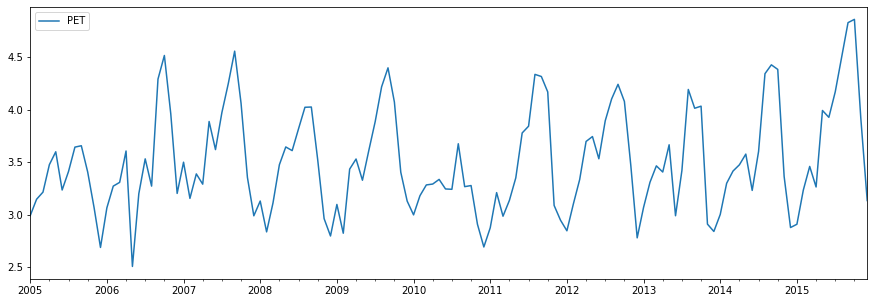

In [ ]:
df_pet.plot();

Sebelum dilakukan _upsampling_ data hanya memiliki $132$ data observasi dengan frekuensi bulanan `MS`.

### Menggunakan _forward fill_ (_default_)

In [ ]:
df_pet_ffill = upsampling(df_pet)
df_pet_ffill.info()
df_pet_ffill.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2005-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
PET    4017 non-null float64
dtypes: float64(1)
memory usage: 62.8 KB


,PET
2005-01-01,2.98897
2005-01-02,2.98897
2005-01-03,2.98897
2005-01-04,2.98897
2005-01-05,2.98897


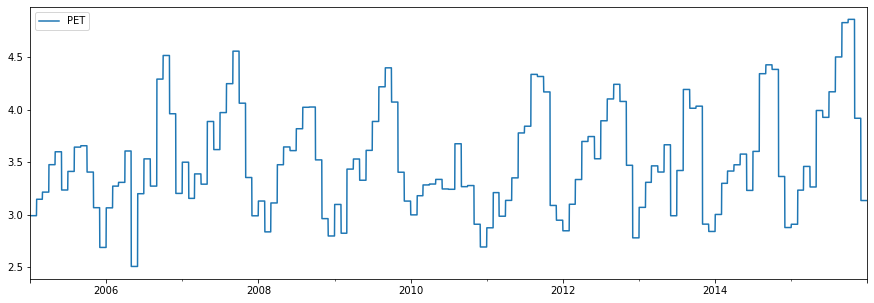

In [ ]:
df_pet_ffill.plot();

Dataframe `df_pet` setelah dilakukan _upsampling_ menjadi $4017$ data observasi dengan frekuensi harian `D`. 

### Menggunakan interpolasi

In [ ]:
df_pet_inter = upsampling(df_pet, use_inter=True, inter_method='linear')
df_pet_inter.info()
df_pet_inter.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2005-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
PET    4017 non-null float64
dtypes: float64(1)
memory usage: 62.8 KB


,PET
2005-01-01,2.988970
2005-01-02,2.994014
2005-01-03,2.999058
2005-01-04,3.004102
2005-01-05,3.009146


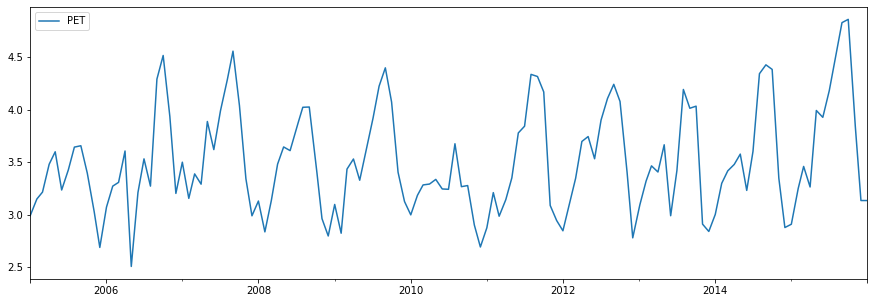

In [ ]:
df_pet_inter.plot();

Perbedaan dengan _forward fill_ dapat dilihat dari grafiknya.

In [ ]:
df_pet_quad = upsampling(df_pet, use_inter=True, inter_method='quadratic')
df_pet_quad.info()
df_pet_quad.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2005-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
PET    3987 non-null float64
dtypes: float64(1)
memory usage: 62.8 KB


,PET
2005-01-01,2.988970
2005-01-02,2.996154
2005-01-03,3.003196
2005-01-04,3.010095
2005-01-05,3.016851


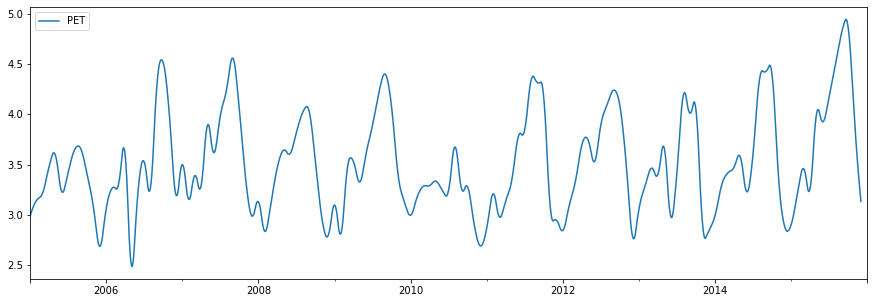

In [ ]:
df_pet_quad.plot();

Jika menggunakan metode `quadratic`, grafik menjadi lebih halus.

### Melakukan _reindex_ saja

Argumen ini disediakan agar memberi kebebasan jika tidak ingin menggunakan metode interpolasi/isian.

In [ ]:
df_pet_re = upsampling(df_pet, reindex=True)
df_pet_re.info()
df_pet_re.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2005-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
PET    132 non-null float64
dtypes: float64(1)
memory usage: 62.8 KB


,PET
2005-01-01,2.98897
2005-01-02,NaN
2005-01-03,NaN
2005-01-04,NaN
2005-01-05,NaN


## Menggabungkan dengan modul `taruma.hk98` (rekap data harian)

Modul ini bisa digabungkan dengan modul `taruma.hk98` yang digunakan untuk merekap data harian.

Karena `df_pet` sudah diubah menjadi data harian (`df_pet_ffill`), maka bisa digabungkan dengan `df_sta`. Dataframe `dataset` dimulai dari tahun 2005 karena `df_pet` hanya dimulai dari tahun 2005.


In [ ]:
dataset = pd.concat([df_sta, df_pet_ffill], axis=1).loc['20050101':]
dataset

,STA_B,PET
2005-01-01,14,2.988970
2005-01-02,0,2.988970
2005-01-03,7,2.988970
2005-01-04,37,2.988970
2005-01-05,0,2.988970
...,...,...
2015-12-27,6,3.133179
2015-12-28,32,3.133179
2015-12-29,0,3.133179
2015-12-30,0,3.133179


Setelah mempersiapkan `dataset`, dapat dilakukan rekap menggunakan modul `taruma.hk98`. Pada data curah hujan, akan dilakukan penjumlahan curah hujan, jumlah hari hujan, jumlah hari periode. Sedangkan pada data PET, hanya merekap dengan merata-ratakan nilainya setiap periode. Periode yang akan digunakan adalah per 11 hari (3 periode).

In [ ]:
from hidrokit.contrib.taruma import hk98

NDAYS = '11D'
n_rain = lambda x: (x>0).sum()
ufunc, ufunc_col = [np.sum, n_rain, len], ['SUM', 'NRAIN', 'NDAYS']

dataset_pet = hk98.summary_station(dataset, 'PET', np.mean, 'PET', 
                                   n_days=NDAYS)
dataset_prep = hk98.summary_station(dataset, 'STA_B', ufunc, ufunc_col, 
                                    n_days=NDAYS)

data_input = pd.concat([dataset_prep, dataset_pet], axis=1)
data_input.columns = data_input.columns.droplevel(0)
data_input.head(10)

,SUM,NRAIN,NDAYS,PET
2005-01-01,102.0,6.0,11.0,2.988970
2005-01-12,0.0,0.0,11.0,2.988970
2005-01-23,0.0,0.0,9.0,2.988970
2005-02-01,0.0,0.0,11.0,3.145340
2005-02-12,0.0,0.0,11.0,3.145340
2005-02-23,0.0,0.0,6.0,3.145340
2005-03-01,0.0,0.0,11.0,3.213324
2005-03-12,0.0,0.0,11.0,3.213324
2005-03-23,0.0,0.0,9.0,3.213324
2005-04-01,0.0,0.0,11.0,3.474628


In [ ]:
data_input.sample(10)

,SUM,NRAIN,NDAYS,PET
2014-07-12,32.0,4.0,11.0,3.601199
2007-12-12,190.0,7.0,11.0,2.987743
2010-06-12,72.0,2.0,11.0,3.243436
2007-12-01,86.0,5.0,11.0,2.987743
2013-03-01,113.0,4.0,11.0,3.463320
2007-07-01,0.0,0.0,11.0,3.970709
2007-03-12,245.0,4.0,11.0,3.386749
2013-11-23,69.0,2.0,8.0,2.908408
2010-07-23,0.0,0.0,9.0,3.240201
2007-10-01,0.0,0.0,11.0,4.060168


# Changelog

```
- 20191219 - 1.1.0 - Initial
```

#### Copyright &copy; 2019 [Taruma Sakti Megariansyah](https://taruma.github.io)

Source code in this notebook is licensed under a [MIT License](https://choosealicense.com/licenses/mit/). Data in this notebook is licensed under a [Creative Common Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/). 
